In [41]:
from rfgap import RFGAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataset import dataprep
from phate import PHATE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read in and prepare the data

data   = pd.read_csv('../datasets/titanic.csv', sep = ',')
x, y   = dataprep(data, scale = None)
n, d   = x.shape
n_classes = len(y.unique())

x_train, x_test, y_train, y_test, inds_train, inds_test = train_test_split(x, y, np.arange(n), test_size=0.1, random_state = 42)

In [3]:
# Random forest on all data for PHATE embedding visualization
rfphate = RFGAP(oob_score = True, non_zero_diagonal = True, random_state = 42)
rfphate.fit(x, y)
prox_phate = rfphate.get_proximities()

In [4]:
# Random forest for uncertainty measures; using split datasets
rf = RFGAP(oob_score = True, random_state = 42)
rf.fit(x_train, y_train)
prox = rf.get_proximities()

In [5]:
# Generate OOB and Test trust scores
trust_scores_oob = rf.get_trust_scores()
trust_scores_test = rf.get_test_trust(x_test)

Currently minus not taking oob_correct into account


In [46]:
def reverse_scale_sklearn(x, min_size = 5, max_size = 100):
    scaler = MinMaxScaler(feature_range = (min_size, max_size))

    return max_size - scaler.fit_transform(x) + min_size

In [62]:
# Helper functions for plots
def reverse_scale(x, min_size = 5, max_size = 100, log_scale = False):
    
    if log_scale:
        x = np.log(x + np.finfo(np.float64).eps)
        x_scaled = max_size - (x - x.min())/(x.max() - x.min()) * max_size + min_size
    else:
        x_scaled = max_size - (x - x.min())/(x.max() - x.min()) * max_size + min_size

    return x_scaled

In [7]:
# RF-PHATE embedding for scatterplots
phate_op = PHATE(knn_dist = 'precomputed')
emb = phate_op.fit_transform(prox_phate)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 712 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.01 seconds.
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 0.25 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.06 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.53 seconds.
Calculated PHATE in 0.89 seconds.


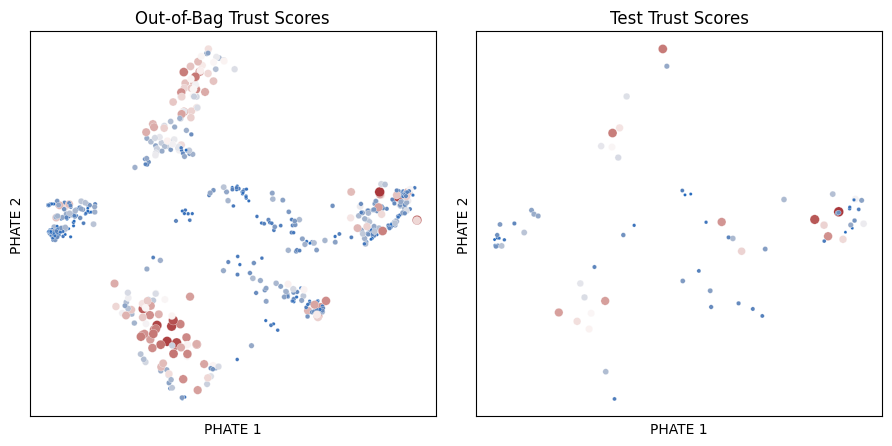

In [75]:
# RF-PHATE train/test plots
fig, axes = plt.subplots(1, 2, figsize = (11, 5))
plt.subplots_adjust(hspace = 0.5, wspace = 0.1)
color_palette = sns.color_palette('vlag', as_cmap = True)


min_size = 5
max_size = 50

oob_scale = reverse_scale(trust_scores_oob, min_size = min_size, max_size = max_size)
test_scale = reverse_scale(trust_scores_test, min_size = min_size, max_size = max_size)

sns.scatterplot(ax = axes[0], x = emb[inds_train, 0], y = emb[inds_train, 1],
                hue = oob_scale, 
                size = oob_scale,
                sizes = (min_size, max_size),
                palette = color_palette)


sns.scatterplot(ax = axes[1], x = emb[inds_test, 0], y = emb[inds_test, 1],
                hue = test_scale, 
                size = test_scale,
                sizes = (min_size, max_size),
                palette = color_palette)


axes[0].set_title('Out-of-Bag Trust Scores')
axes[1].set_title('Test Trust Scores')

for ax in axes:
    ax.set_xlabel('PHATE 1')
    ax.set_ylabel('PHATE 2')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend([], [], frameon = False)

In [79]:
# Get trust score quantiles for both OOB and Test points
oob_trust_quantiles = rf.trust_quantiles
test_trust_quantiles = rf.trust_quantiles_test

In [112]:
np.diff(oob_trust_quantiles)

array([0.0635424 , 0.09322138, 0.01099805, 0.02531046, 0.01652418,
       0.03313979, 0.02434335, 0.01488207, 0.02053929, 0.01691582,
       0.0102673 , 0.02198501, 0.01377472, 0.01621631, 0.03176459,
       0.02089746, 0.00992333, 0.02878429, 0.01527506, 0.01772608,
       0.01294467, 0.01622151, 0.01052151, 0.02070295, 0.01557781,
       0.01091873, 0.00785408, 0.00872174, 0.00593275, 0.00382589,
       0.00995245, 0.00859736, 0.00303738, 0.0068571 , 0.00566432,
       0.00456364, 0.00903383, 0.0066629 , 0.0034524 , 0.00821329,
       0.00383122, 0.0052326 , 0.00415257, 0.00653071, 0.01245947,
       0.01015733, 0.00701448, 0.00567108, 0.00487879, 0.00363433,
       0.00222226, 0.00177081, 0.0082722 , 0.00996564, 0.00547984,
       0.00471222, 0.00262933, 0.00433768, 0.00231442, 0.00392376,
       0.00366222, 0.00212311, 0.00221161, 0.00475042, 0.00244892,
       0.00195433, 0.00411142, 0.00198632, 0.00402439, 0.00263275,
       0.0036884 , 0.00432597, 0.00300035, 0.00466222, 0.00222

In [109]:
# The number of points dropped based on low trust quantiles
n_oob_dropped = []
n_test_dropped = []

for q in oob_trust_quantiles:
    n_oob_dropped.append(np.sum(trust_scores_oob < q))


for q in oob_trust_quantiles:
    n_test_dropped.append(np.sum(trust_scores_test < q))

Text(0.5, 0, 'Trust Score Quantiles')

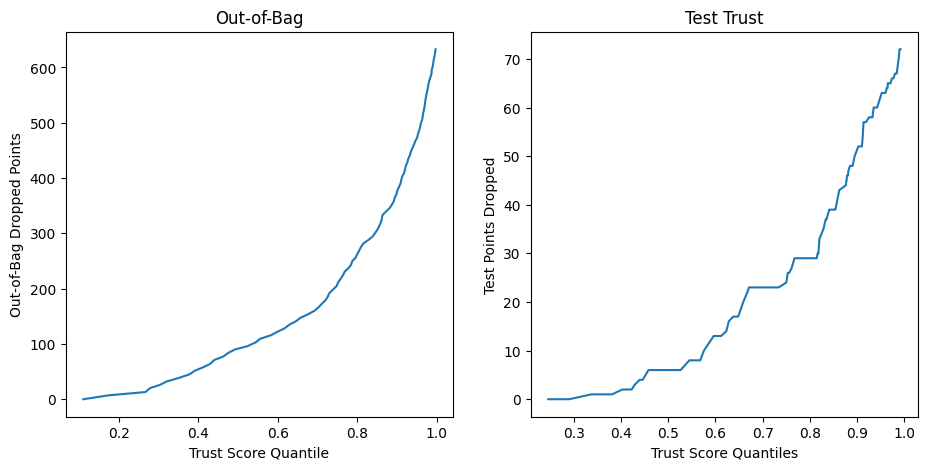

In [118]:
# Plot of test  and oob trust score quantiles
fig, axes = plt.subplots(1, 2, figsize = (11, 5))


sns.lineplot(ax = axes[0], x = oob_trust_quantiles, y = n_oob_dropped)
sns.lineplot(ax = axes[1], x = test_trust_quantiles, y = n_test_dropped)


axes[0].set_title('Out-of-Bag')
axes[0].set_ylabel('Out-of-Bag Dropped Points')
axes[0].set_xlabel('Trust Score Quantile')

axes[1].set_title('Test Trust')
axes[1].set_ylabel('Test Points Dropped')
axes[1].set_xlabel('Trust Score Quantiles')

In [ ]:
# TODO: Plot about increased accuracy with dropped points